In [2]:
import os
import sys
import time
import re
import numpy as np
from numpy import *
from pylab import *
from scipy import *
from matplotlib.pyplot import *
import matplotlib.pyplot as plt


import stan

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [3]:
%matplotlib inline

In [5]:
Mainpath = '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialsCompareModels/'

In this toy example, we first generate a synthetic data  using a second-order polynomial and we then fit different models  (polynomials order 1,2, 3, and 5) in order to see which model best explains the generated data.

# Generate Synthetic Data

In [6]:
a = 5
b = 5
c=5
sigma=1
random.seed(11442)
noise =sigma * randn() 

In [7]:
nt = 100
t = linspace(-5, 5, nt)
y = a*(t**2)+b*t+c
y_model = y+sigma*randn(y.size)

In [8]:
nt_outl=2
t_outl=linspace(5, 6, nt_outl)
y_outl=35*t_outl

In [9]:
nt_obs=nt+nt_outl
t_obs=concatenate((t,t_outl), axis=0)
yobs=concatenate((y_model,y_outl), axis=0)

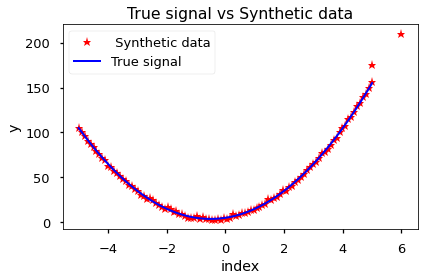

In [10]:
figure(figsize=(6, 4))
plot(t_obs,yobs,'r*', label=' Synthetic data' )
plot(t,y, color='b', linewidth=2.0, label='True signal')
xlabel("index")
ylabel("y")
title('True signal vs Synthetic data')
legend()
tight_layout()
show() 



# Save Data to run Stan

In [11]:
! mkdir -p  data_input_files

In [12]:
data_input= {'nt': nt_obs, 't': t_obs, 'yobs': yobs}


nd=[]
npz = {'nd': nd}
npz.update(data_input)


np.savez(Mainpath+'/data_input_files/'+'data_input.R.npz', **npz)
np.savez(Mainpath+'/data_input_files/'+'data_input.npz', **npz)
pystan.stan_rdump(data_input, Mainpath+'/data_input_files/'+'data_input.R')


FileNotFoundError: [Errno 2] No such file or directory: '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialsCompareModels//data_input_files/data_input.R.npz'

In [ ]:
data_input = dict(load(Mainpath+'/data_input_files/'+'data_input.R.npz'))

In [ ]:
#data = pystan.read_rdump('data.R')
# savez('data_input.npz', **npz)
# savez('data_input.R.npz', **npz)
# pystan.stan_rdump(data_input, 'data_input.R')

Stan does not automatically compute and store the log-likelihood. It is up to the user to incorporate it into the Stan program if it is to be extracted after fitting the model. In a Stan model, the pointwise log likelihood can be coded as a vector in the transformed parameters block (and then summed up in the model block) or it can be coded entirely in the generated quantities block. We recommend using the generated quantities block so that the computations are carried out only once per iteration rather than once per HMC leapfrog step. 


log_lik[i] = normal_lpdf(data[i] | model[i], sd)
 
 
Value: An S by N matrix of (post-warmup) extracted draws, where S is the size of the posterior sample and N is the number of data points. 

# Fit Polynomial order 1

In [ ]:
model_poly1 = open('model_poly1.stan').read()    
print(model_poly1)


# with open('model_poly1.stan', 'r') as file:
#     print(file.read())
# model =pystan.StanModel(file='model_poly2.stan')

In [ ]:
tic=time.time()
model1 =pystan.StanModel(model_code=model_poly1) 
print(time.time()- tic, 'second is required to run')

In [ ]:
alg_type = "hmc"

In [ ]:
tic=time.time()

if alg_type == "hmc":
            fit1 = model1.sampling(data=data_input, algorithm='NUTS', iter=2000,  warmup=500, 
                      control=dict(adapt_delta=0.85), chains=1, n_jobs=-1, verbose=True, refresh=500) 
else: 
            fit1 = model1.vb(data=data_input, algorithm='meanfield',  iter=1e+5,  tol_rel_obj=1e-5, 
                             elbo_samples=1000 , output_samples=1000, verbose=True)

print(time.time() - tic, 'second is required to run')

In [ ]:
fit1.plot()
show()
print (fit1)

In [ ]:
Rhat=fit1.summary()['summary'][:, -1]
R_norm=sum(Rhat)/Rhat.size
print('Normalized R=', float(R_norm))
plt.figure(figsize=(5,4))
plt.hist(Rhat);
xlabel('R value')
ylabel('Count')
title(r'$\hat R$');
show()

In [ ]:
traces=fit1.extract(permuted=True)

In [ ]:
p_l,p_h =percentile(traces['p'], [2.5,97.5], axis=0)
p_est=mean(traces['p'], axis=0)

In [ ]:
Np=traces['p'].shape[1]

In [ ]:
figure(figsize=(12,3))
for i in range(Np):
     subplot(1, Np, i + 1)  
     hist(traces['p'][:,i], bins=10);
     axvline(p_est[i], color='r')
     title(f'p_{i}') 
show()

In [ ]:
y_fit= polyval(p_est[::-1], t_obs)
y_fit_l=polyval(p_l[::-1], t_obs)
y_fit_h=polyval(p_h[::-1], t_obs)

In [ ]:
#y_fit1 = p1_est*pow(t,1)+p0_est*pow(t,0)

In [ ]:
figure(figsize=(6, 4))

plot(t,y, color='b', linewidth=2.0, label='True signal')
plot(t_obs, yobs,'r*', label=' Synthetic data' )
plot(t_obs, y_fit,'g--o', label='fitted signal' )
fill_between(t_obs, y_fit_l, y_fit_h, alpha=0.2, facecolor='g', edgecolor='none')

xlabel("index")
ylabel("y")
title('Model 1')
legend()
tight_layout()
show() 

# Fit Polynomial order 2


In [ ]:
model_poly2 = open('model_poly2.stan').read()    
print(model_poly2)

In [ ]:
tic=time.time()
model2 =pystan.StanModel(model_code=model_poly2) 
print(time.time()- tic, 'second is required to run')

In [ ]:
fit2 = model2.sampling(data=data_input, iter=2000, warmup=500, chains=1, n_jobs=-1, verbose=True, refresh=10)    

In [ ]:
fit2.plot()
show()
print (fit2)

In [ ]:
Rhat=fit2.summary()['summary'][:, -1]
R_norm=sum(Rhat)/Rhat.size
print('Normalized R=', float(R_norm))
plt.figure(figsize=(5,4))
plt.hist(Rhat);
xlabel('R value')
ylabel('Count')
title(r'$\hat R$');
show()

In [ ]:
traces=fit2.extract(permuted=True)

In [ ]:
p_l,p_h =percentile(traces['p'], [2.5,97.5], axis=0)
p_est=mean(traces['p'], axis=0)

In [ ]:
Np=traces['p'].shape[1]

In [ ]:
figure(figsize=(16,3))
for i in range(Np):
     subplot(1, Np, i + 1)  
     hist(traces['p'][:,i], bins=10);
     axvline(p_est[i], color='r')
     title(f'p_{i}') 
show()

In [ ]:
y_fit= polyval(p_est[::-1], t_obs)
y_fit_l=polyval(p_l[::-1], t_obs)
y_fit_h=polyval(p_h[::-1], t_obs)

In [ ]:
figure(figsize=(6, 4))

plot(t, y, 'bo', linewidth=1.0, label='True signal')
plot(t_obs, yobs,'r*', label=' Synthetic data' )
plot(t_obs, y_fit,'y--.', label='fitted signal' )
fill_between(t_obs, y_fit_l, y_fit_h, alpha=0.2, facecolor='g', edgecolor='none')

xlabel("index")
ylabel("y")
title(' Model 2')
legend()
tight_layout()
show() 

# Fit Polynomial order 3

In [ ]:
model_poly3 = open('model_poly3.stan').read()    
print(model_poly3)

In [ ]:
tic=time.time()
model3 =pystan.StanModel(model_code=model_poly3) 
print(time.time()- tic, 'second is required to run')

In [ ]:
fit3 = model3.sampling(data=data_input, iter=2000, warmup=500, chains=1, n_jobs=-1, verbose=True, refresh=10)    

In [ ]:
fit3.plot()
show()
print (fit3)

In [ ]:
Rhat=fit3.summary()['summary'][:, -1]
R_norm=sum(Rhat)/Rhat.size
print('Normalized R=', float(R_norm))
plt.figure(figsize=(5,4))
plt.hist(Rhat);
xlabel('R value')
ylabel('Count')
title(r'$\hat R$');
show()

In [ ]:
traces=fit3.extract(permuted=True)

In [ ]:
p_l,p_h =percentile(traces['p'], [2.5,97.5], axis=0)
p_est=mean(traces['p'], axis=0)

In [ ]:
Np=traces['p'].shape[1]

In [ ]:
figure(figsize=(18,3))
for i in range(Np):
     subplot(1, Np, i + 1)  
     hist(traces['p'][:,i], bins=10);
     axvline(p_est[i], color='r')
     title(f'p_{i}') 
show()

In [ ]:
y_fit= polyval(p_est[::-1], t_obs)
y_fit_l=polyval(p_l[::-1], t_obs)
y_fit_h=polyval(p_h[::-1], t_obs)

In [ ]:
figure(figsize=(6, 4))

plot(t, y, 'bo', linewidth=1.0, label='True signal')
plot(t_obs, yobs,'r*', label=' Synthetic data' )
plot(t_obs, y_fit,'y--.', label='fitted signal' )
fill_between(t_obs, y_fit_l, y_fit_h, alpha=0.2, facecolor='g', edgecolor='none')

xlabel("index")
ylabel("y")
title(' Model 3')
legend()
tight_layout()
show() 

# Fit Polynomial order 5

In [ ]:
model_poly5 = open('model_poly5.stan').read()    
print(model_poly5)

In [ ]:
tic=time.time()
model5 =pystan.StanModel(model_code=model_poly5) 
print(time.time()- tic, 'second is required to run')

In [ ]:
fit5 = model5.sampling(data=data_input, iter=2000, warmup=500, chains=1, n_jobs=-1, verbose=True, refresh=10)    

In [ ]:
fit5.plot()
show()
print (fit5)

In [ ]:
Rhat=fit5.summary()['summary'][:, -1]
R_norm=sum(Rhat)/Rhat.size
print('Normalized R=', float(R_norm))
plt.figure(figsize=(5,4))
plt.hist(Rhat);
xlabel('R value')
ylabel('Count')
title(r'$\hat R$');
show()

In [ ]:
traces=fit5.extract(permuted=True)

In [ ]:
p_l,p_h =percentile(traces['p'], [2.5,97.5], axis=0)
p_est=mean(traces['p'], axis=0)

In [ ]:
Np=traces['p'].shape[1]

In [ ]:
figure(figsize=(20,3))
for i in range(Np):
     subplot(1, Np, i + 1)  
     hist(traces['p'][:,i], bins=10);
     axvline(p_est[i], color='r')
     title(f'p_{i}') 
show()

In [ ]:
y_fit= polyval(p_est[::-1], t_obs)
y_fit_l=polyval(p_l[::-1], t_obs)
y_fit_h=polyval(p_h[::-1], t_obs)

In [ ]:
figure(figsize=(6, 4))

plot(t, y, 'bo', linewidth=1.0, label='True signal')
plot(t_obs, yobs,'r*', label=' Synthetic data' )
plot(t_obs, y_fit,'y--.', label='fitted signal' )
fill_between(t_obs, y_fit_l, y_fit_h, alpha=0.2, facecolor='g', edgecolor='none')

xlabel("index")
ylabel("y")
title(' Model 5')
legend()
tight_layout()
show() 

Note that, R hat is equal to 1 (or very close to 1), for all parameters of each considered models.

# Model Evaluation & Model Comparison

** Diagnostic measures to estimate the reliability of inference**: 


* CV: cross-validation 

** Good approximate for CV**: 

* WAIC: Watanabe-Akaike or widely applicable information criterion

* PSIS-LOO: (Efficient approximate leave-one-out cross-validation for Bayesian models).

* LOO: Leave-one-out cross-validation

* PSIS: Pareto smoothed importance sampling. 



**WAIC**


WAIC and PSIS-LOO are methods for estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian model using the log-likelihood evaluated at the posterior simulations of the parameter values.


WAIC and PSIS-LOO  have various advantages over simpler estimates of predictive error such as AIC and DIC but are less used in practice because they involve additional computational steps.



AIC ignores priors and assumes that the posterior distribution is multivariate normal, whereas the functions from the LOO do not make this distributional assumption and integrate over uncertainty in the parameters. This only assumes that any one observation can be omitted without having a major effect on the posterior distribution.


WAIC is based on the series expansion of LOO, and asymptotically they are equal. 

With finite data, WAIC and CV address different predictive questions and thus it is useful to be able to compute both.  


WAIC and an  PSIS-OO can be estimated directly using the log-likelihood evaluated at the posterior simulations of the parameter value.


The exact LOO, in practice would usually not be computed because of its computational cost.


In sum, WAIC enable an approximation of the exact LOO without requiring refitting of the model.

**How we can compute WAIC in stan?!**

*The log likelihood required  for  WAIC  and  PSIS-LOO  is  added  on  to  the  model  in  the  generated  quantities  block.*


** K -fold cross-validation**

To implement K-fold cross-validation in Stan we need to repeatedly fit the model to one subset of
the data and use it to predict the held-out set.



# Information criteria


* WAIC: Watanabe-Akaike or widely applicable information criterion (prefreed to below criteria since it is fully Bayesian)


* DIC: deviance information criterion (generalization of the AIC and the BIC)


* AICC: (generalization of the AIC)


* AIC: Akaike information criterion 


* BIC: Bayesian information criterion
 


** WAIC**

WAIC can be viewed as an improvement on the DIC for Bayesian models.

DIC is  not  being  fully  Bayesian  in that it is based on a point estimate ( For example, DIC can produce negative estimates of the effective number of parameters in a model and it is not defined for singular models).


WAIC is fully Bayesian and closely approximates Bayesian cross-validation. Unlike DIC, WAIC is invariant to parametrization and also works for singular models.


Exact cross-validation requires re-fitting the model with different training sets.  Approximate LOO can be computed easily using truncated importance sampling.






To keep comparability with the given dataset and to get easier interpretation of the differences in scale of effective number of parameters, we define a measure of predictive accuracy for the
n data points taken opointwisene at a time:

*elpd   =   expected log pointwise predictive density for a new dataset.*


we will use WAIC to approximate elpd.


A helpful quantity in the analysis is:

lpd   =  computed  log pointwise predictive density


WAIC  can  be  interpreted  as  a  computationally  convenient  approximation  to cross-validation and is defined based on:

elpd_waic = lpd - p_waic,

where p_waic is the estimated effective number of parameters, which we can calculate using the posterior variance of the log predictive density for each data point (i.e., variance-based computation of number of parameters).


Finally, 

WAIC = -2 * elpd_waic

* WAIC is a way of measuring the fit of Bayesian models. It is conceptually similar to AIC and BIC. Like AIC and BIC, lower values of WAIC indicate a better model fit.

**DIC**

DIC is a hierarchical modeling generalization of the AIC and the BIC. It is particularly useful in Bayesian model selection problems where the posterior distributions of the models have been obtained by MCMC.


Define the deviance as  $D(\theta )=-2\log(p(y|\theta ))+C$, where  y are the data,  $\theta$  are the unknown parameters of the model and  p(y|$\theta$ ), is the likelihood function. 

 C, is a constant that cancels out in all calculations that compare different models, and which therefore does not need to be known.
 
The models with smaller DIC should be preferred to models with larger DIC.

**AIC**

Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection (it deals with the trade-off between the goodness of fit of the model and the simplicity of the model).

AIC tells nothing about the absolute quality of a model, only the quality relative to other models. Thus, if all the candidate models fit poorly, AIC will not give any warning of that.


 Let k be the number of estimated parameters in the model. Let  $\hat L$ be the maximum value of the likelihood function for the model. Then the AIC value of the model is 

$ \mathrm {AIC} =2k-2\ln({\hat {L}})$


Given a set of candidate models for the data, the preferred model is the one with the minimum AIC value. Thus, AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters. The penalty discourages overfitting, because increasing the number of parameters in the model almost always improves the goodness of the fit.

**AICc**

When the sample size is small, there is a substantial probability that AIC will select models that have too many parameters, i.e. that AIC will overfit. To address such potential overfitting, AICc was developed: AICc is AIC with a correction for small sample sizes.

The formula for AICc depends upon the statistical model. Assuming that the model is univariate, is linear in its parameters, and has normally-distributed residuals (conditional upon regressors), then the formula for AICc is as follows:

$\mathrm {AICc} =\mathrm {AIC} +{\frac {2k^{2}+2k}{n-k-1}}$,

where n denotes the sample size and k denotes the number of parameters. Thus, AICc is essentially AIC with an extra penalty term for the number of parameters. Note that as n → ∞, the extra penalty term converges to 0, and thus AICc converges to AIC.

so,  AICc has the advantage of tending to be more accurate than AIC (especially for small samples).


The formula for the BIC is similar to the formula for AIC, but with a different penalty for the number of parameters. With AIC the penalty is 2k, whereas with BIC the penalty is ln(n) k.

**BIC**

 
 
BIC is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. 
It is based, in part, on the likelihood function and it is closely related to the AIC.


When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC.



The BIC is formally defined as: 

${\displaystyle \mathrm {BIC} ={\ln(n)k-2\ln({\hat {L}})}.\ } $, where

$\hat L$ = the maximized value of the likelihood function of the model  M, i.e. $ \hat L=p(x|\theta_{mle})$,


where $ { {\theta_{mle} }}$ are the parameter values that maximize the likelihood function;

 x = the observed data;
 
 n = the number of data points in  x, the number of observations.
 
 k = the number of parameters estimated by the model.

**using the output from the Stan fit, in ComputeICs.py the ICc are computed as:**


log_lik: log of likelihood, with size of s x n where s is number of samples and n is number of data points.


maxlike: max of log_like,

k = nparams,

n = ndata,

s=nsamples,
    
    
    

lpd=np.sum(np.log(np.mean(np.exp(log_like),axis=0))),
    
    
p_waic = np.sum(var(log_like, axis=0, dtype=np.float64)), 
    
    
elpd_waic = lpd - p_waic, 
	
    
    

* waic = -2 * elpd_waic


* aic: 2 * k - 2 * log_like.max()


* aicc: aic + 2 * k * (k + 1) / (n - k - 1)


* bic: -2 * log_like.max() + k * log(n)
 
 

** Refs:**

* Understanding predictive information criteria for Bayesi
an models:

https://arxiv.org/pdf/1307.5928.pdf

* WAIC and cross-validation in Stan:

http://www.stat.columbia.edu/%7Egelman/research/unpublished/waic_stan.pdf

* Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC:

https://arxiv.org/pdf/1507.04544.pdf


* Yes, but Did It Work?: Evaluating Variational Inference:
https://arxiv.org/pdf/1802.02538.pdf


* PSIS:
https://github.com/avehtari/PSIS




** useful recources:**

* https://github.com/JohannesBuchner/ic4stan

* https://github.com/stan-dev/stan/issues/473

* http://kylehardman.com/BlogPosts/View/7


# Measuring information criteria and LOO

In [ ]:
tic=time.time()
!./RunIC.sh 
print('total running time is: ', time.time()- tic, 'second')

In [ ]:
!ls

# Plot  functions

In [ ]:
error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

def bestmodel_barplot(y, y_err):
    bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
    bar(argmin(y), y[argmin(y)], yerr=y_err[argmin(y)], color='r',  error_kw=error_kw_red, label="Best Model")
    xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))], rotation=30);
    return

In [ ]:
def scatter_plot(y): 
    from matplotlib import cm
    #colors = cm.seismic(y / float(max(y)))
    plot = plt.scatter(r_[:y.shape[0]]+1, y, c = y, cmap = 'seismic', lw=4)
    plt.colorbar(plot)
    #plt.stem(r_[:y.shape[0]]+1, y, color = colors,linewidth=2, basefmt=" ")
    return 

In [ ]:
def k_count(y,y_thr): 
    k=((y > y_thr).sum()/y.size)*100   
    return k

In [ ]:
import re
import glob
from operator import itemgetter

cwd = os.getcwd()
os.chdir(cwd)

numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Plot information criteria

Lets see what we have in the current dir!

In [ ]:
allStanFiles = sorted(glob.glob(cwd + "/*.stan"), key=numericalSort)

allStanFiles

In [ ]:
Models= [x.rsplit('/')[-1].rsplit('.stan')[-2] for x in allStanFiles]

print(Models)

In [ ]:
allReport_textFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

allReport_textFiles

In [ ]:
all_IcFiles= [x.rsplit('/')[-1] for x in allReport_textFiles if 'Ic' in x]

all_IcFiles

In [ ]:
!cat model_poly1.stan_report_Ic.txt

In [ ]:
!cat model_poly2.stan_report_Ic.txt

In [ ]:
IC_elements = []
with open(all_IcFiles[0], 'r') as fd:
    for line in fd.readlines():
        IC_elements.append(line.strip().split()[0])
        
IC_elements

In [ ]:
maxlike_idx=IC_elements.index('maxlike')
p_waic_idx=IC_elements.index('p_waic')
elpd_waic_idx=IC_elements.index('elpd_waic')
waic_idx=IC_elements.index('waic')
dic_idx=IC_elements.index('dic')
aicc_idx=IC_elements.index('aicc')
aic_idx=IC_elements.index('aic')
bic_idx=IC_elements.index('bic')

In [ ]:
IC=[loadtxt(x, delimiter=',', usecols=(1) ).T for x in all_IcFiles]
IC_err=[loadtxt(x, delimiter=',', usecols=(2) ).T for x in all_IcFiles]

IC=asarray(IC)
IC_err=asarray(IC_err)

In [ ]:
figure(figsize=(14, 30))

error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

for i in range(len(IC_elements)):
     subplot(len(IC_elements)//2+1, 2, i + 1)  
     y=[IC[j][i]  for j in range(0,len(IC))]
     y_err=[IC_err[j][i]  for j in range(0,len(IC))]

     if i in (elpd_waic_idx, maxlike_idx):
         bar(r_[:len(IC)], y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
         barlist= bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red, label="Best Model")
     else:
         bar(r_[:len(IC)], y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
         barlist= bar(argmin(y), y[argmin(y)], yerr=y_err[argmin(y)], color='r',  error_kw=error_kw_red, label="Best Model")
     #xticks(r_[:len(IC)], [Models[j]  for j in range(0,len(IC))], rotation=70);
     xticks(r_[:len(IC)], ['Model1','Model2','Model3','Model4' ], rotation=0);
     ylabel('IC')
     title(IC_elements[i])
     legend()

show() 

In [ ]:
elpd_waic=[IC[j][elpd_waic_idx]  for j in range(0,len(IC))]
p_waic=[IC[j][p_waic_idx]  for j in range(0,len(IC))]
waic=[IC[j][waic_idx]  for j in range(0,len(IC))]
dic=[IC[j][dic_idx]  for j in range(0,len(IC))]
aicc=[IC[j][aicc_idx]  for j in range(0,len(IC))]
aic=[IC[j][aic_idx]  for j in range(0,len(IC))]
bic=[IC[j][bic_idx]  for j in range(0,len(IC))]

In [ ]:
elpd_waic_err=[IC_err[j][elpd_waic_idx]  for j in range(0,len(IC_err))]
p_err=[IC_err[j][p_waic_idx]  for j in range(0,len(IC_err))]
waic_err=[IC_err[j][waic_idx]  for j in range(0,len(IC_err))]
dic_err=[IC_err[j][dic_idx]  for j in range(0,len(IC_err))]
aicc_err=[IC_err[j][aicc_idx]  for j in range(0,len(IC_err))]
aic_err=[IC_err[j][aic_idx]  for j in range(0,len(IC_err))]
bic_err=[IC_err[j][bic_idx]  for j in range(0,len(IC_err))]

In [ ]:
figure(figsize=(14, 14))

subplot(221)
y = waic
y_err = waic_err
bestmodel_barplot(y, y_err)
ylabel("WAIC")

subplot(222)
y = aicc
y_err = aicc_err
bestmodel_barplot(y, y_err)
ylabel("AICc")

subplot(223)
y = aic
y_err = aic_err
bestmodel_barplot(y, y_err)
ylabel("AIC")

subplot(224)
y = bic
y_err = bic_err
bestmodel_barplot(y, y_err)
ylabel("BIC")

show()

# Which One?!

In [ ]:
Best_model=[]

if "waic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,waic_idx]), key=itemgetter(1))[0]+1)
if "dic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,dic_idx]), key=itemgetter(1))[0]+1)    
if "aicc" in IC_elements:
    Best_model.append(min(enumerate(IC[:,aicc_idx]), key=itemgetter(1))[0]+1)
if "aic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,aic_idx]), key=itemgetter(1))[0]+1)
if "bic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,bic_idx]), key=itemgetter(1))[0]+1)

In [ ]:
print('Best model is model: ', Best_model)

Given a set of candidate models for the data, the preferred model is the one with the minimum AIC value.

In [ ]:
Best_model_elpd_waic=max(enumerate(elpd_waic), key=itemgetter(1))[0]+1
print('Best model according to elpd_waic is model', Best_model_elpd_waic)

In [ ]:
Best_model_waic=min(enumerate(waic), key=itemgetter(1))[0]+1
print('Best model according to WAIC is model', Best_model_waic)

In [ ]:
Best_model_dic=min(enumerate(dic), key=itemgetter(1))[0]+1
print('Best model according to DIC is model', Best_model_dic)

In [ ]:
Best_model_aicc=min(enumerate(aicc), key=itemgetter(1))[0]+1
print('Best model according to AICc is model', Best_model_aicc)

In [ ]:
Best_model_aic=min(enumerate(aic), key=itemgetter(1))[0]+1
print('Best model according to AIC is model', Best_model_aic)

In [ ]:
Best_model_bic=min(enumerate(bic), key=itemgetter(1))[0]+1
print('Best model according to BIC is model', Best_model_bic)

# PSIS

After fitting a Bayesian model we often want to measure its predictive accuracy, for its own sake
or for purposes of model comparison,  selection,  or averaging.  Cross-validation and information
criteria are two approaches for estimating out-of-sample predictive accuracy using within-sample
fits.

The basic idea of LOO is to split the data such that each training set used for estimating the parameters only excludes one observation, while one observation is validated. 


However, the robustness of LOO is achieved by fitting a model as many times as the
number of observations, which is prohibitive in terms of time for complex models. In order to reduce computation time, it is possible to use an approximation of LOO or to reduce the
number of models to be fit. We can approximate LOO with Pareto smoothed importance sampling (PSIS-LOO; Vehtari & Gelman, 2015).

Exact cross-validation requires re-fitting the model with different training sets. Approximate leave-
one-out cross-validation (LOO) can be computed easily using importance sampling (Gelfand, Dey,
and Chang, 1992, Gelfand, 1996) but the resulting estimate is noisy, as the variance of the impor-
tance weights can be large or even infinite (Peruggia, 1997, Epifani et al., 2008). Here we propose
a novel approach that provides a more accurate and reliable estimate using importance weights that
are smoothed by fitting a generalized Pareto distribution to the upper tail of the distribution of the
importance weights.

WAIC is asymptotically equal to LOO, and can thus be used as an approximation to LOO. In the finite case,  WAIC and LOO often give very similar estimates, but for influential observations WAIC underestimates the effect
of leaving out one observation.

**efficient PSIS-LOO approximation to exact LOO-CV:**

PSIS: an efficient computation of LOO using Pareto-smoothed importance sampling.


From existing posterior simulation draws, we compute LOO using Pareto smoothed importance sampling (PSIS), a new procedure for regularizing importance weights.


Although WAIC is asymptotically equal to LOO, we demonstrate that PSIS-LOO is more robust in the finite case with weak priors or influential observations.



*RunPsis.sh* Computes the log predictive densities given posterior samples of the log likelihood terms: math:`p(y_i|$\theta^s)` in input parameter `log_lik`.



**`loo`**:  sum of the leave-one-out log predictive densities, i.e., 


**`loo`**=sum(**`loos`**),


**`loos`**: individual leave-one-out log predictive density terms 



**`ks`**: an estimate of Pareto tail indeces.


**Pareto k diagnostic**:


The reliability of the PSIS-based estimates can be assessed using the estimates for the shape parameter k

of the generalized Pareto distribution:

* If k<1/2: the variance of the raw importance ratios is finite, the central limit theorem holds, and the estimate converges quickly.

* If k: is between 1/2 and 1 the variance of the raw importance ratios is infinite but the mean exists, the generalized central limit theorem for stable distributions holds, and the convergence of the estimate is slower. The variance of the PSIS estimate is finite but may be large.

* If k>1: the variance and the mean of the raw ratios distribution do not exist. The variance of the PSIS estimate is finite but may be large.


** In practice,  good performance can be observed for values of k up to 0.7**

**The estimates are unreliable if tail index ``k > 1.0`` **

# Measuring PSIS-LOO

In [ ]:
Chains= ['chain 1', 'chain 2', 'chain 3','chain 4' ]

PSIS_elements=['loo', 'loos', 'ks']

In [ ]:
allReport_txtFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

all_PsisFiles= [x.rsplit('/')[-1] for x in allReport_txtFiles if  'psis' in x]

all_PsisFiles

In [ ]:
PSISs=[pystan.read_rdump(psis_file) for psis_file in all_PsisFiles]
PSISs=asarray(PSISs)

In [ ]:
PSISs

In [ ]:
# ￼for i in range(len(PSISs)):
#     print ('for model_%d.stan:' % (i+1, ))
#     for key, val in PSISs[i].items():
#         print(key, val.shape)

In [ ]:
PSISs_dict = {}
for i in range(len(all_PsisFiles)):
    model = 'model' + str(i)
    PSISs_dict[model] = pystan.read_rdump(all_PsisFiles[i])

In [ ]:
#psis_file_1='model_poly1.stan_report_psis.csv'
#psis_dict_1 =pystan.read_rdump(psis_file_1)

PSISs[0]['loo'], PSISs_dict['model0']['loo']

In [ ]:
figure(figsize=(14, 14))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     Loos=PSISs[i]['loos']
     Loos_mean=mean(Loos, axis=0)
     Loos_err=var(Loos, axis=0)
     bar(r_[:len(Loos_mean)], Loos_mean, width=0.3, color='b', alpha=0.8); 
     errorbar(r_[:len(Loos_mean)], y=Loos_mean, yerr=Loos_err, fmt='none', ecolor='b', capsize=4, elinewidth=1);  
     plt.margins(0.1, 0.1)
     ylabel('loos')
     xlabel('data points')
     title(Models[i])
    
show() 

In [ ]:
figure(figsize=(24,12))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     y=PSISs[i]['loo']
     scatter_plot(y)
     xticks(r_[:len(Chains)]+1, [Chains[i] for i in range(0,len(Chains))]);
     ylabel('loo')
     title(Models[i])
       
show() 

In [ ]:
Loo=[]
Loo_err=[]
for i in range(len(all_PsisFiles)):
    Loo.append(PSISs[i]['loo'].mean())
    Loo_err.append(PSISs[i]['loo'].std())

In [ ]:
print ('elpd_waic =',  asarray(elpd_waic))
print()
print ('PSIS-LOO =',  asarray(Loo)) 
print()
print ('the difference between elpd_waic and PSIS-LOO =', subtract(asarray(Loo) , asarray(elpd_waic)) )


In [ ]:
error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

figure(figsize=(14, 14))

subplot(221)
y = elpd_waic
y_err = elpd_waic_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))],rotation=30);
title("elpd_waic")

subplot(222)
y = Loo
y_err = Loo_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))], rotation=30);
title("PSIS-LOO")
show()

In [ ]:
figure(figsize=(18, 14))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     y=PSISs[i]['ks']
     k_=k_count(y,1.)
     for j in range(len(Chains)):
            yj=y[j,:]
            plot = plt.scatter(r_[:yj.shape[0]] , yj, c = yj, cmap = 'seismic', lw=4)
            yallj=yj.flatten()
            plotallj = plt.scatter(r_[:yallj.shape[0]] , yallj, c = yallj, cmap = 'seismic', lw=4)
     plt.colorbar(plotallj)       
     plt.hlines(y=1., xmin=0., xmax=yj.shape[0], linewidth=.5, color = 'skyblue', linestyle='--' )
     text(-1,0.99, "$k=1.$", size=10, color = 'skyblue')
     text(-1, 1.2,  r'$k > 1.:\ \ $'+str(k_)+r'$\%$' , size=10, color = 'red')
     ylim([-1,3.])
     plt.margins(0.11, 0.1)
     #norm_colorbar(y.flatten())
     ylabel('ks')
     xlabel('data points')
     title(Models[i])

show() 

In [ ]:
figure(figsize=(18, 14))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     y=PSISs[i]['ks']
     yall=y.flatten()
     plotall = plt.scatter(r_[:yall.shape[0]] , yall, c = yall, cmap = 'seismic', lw=4)
     k_=k_count(y,1.)
     for j in range(len(Chains)):
            yj=y[j,:]
            plot = plt.scatter(r_[:yj.shape[0]] , yj, c = yj, cmap = 'seismic', lw=4)
     plt.hlines(y=1., xmin=0., xmax=yj.shape[0], linewidth=.5, color = 'skyblue', linestyle='--' )
     text(-1,0.98, "$k=1.$", size=10, color = 'skyblue')
     text(-1, 1.1,  r'$k > 1.:\ \ $'+str(k_)+r'$\%$' , size=10, color = 'red')
     ylim([-1,3.])
     plt.margins(0.11, 0.1)
     plt.colorbar(plotall)
     ylabel('ks')
     xlabel('data points* 4 chains')
     title(Models[i])

show() 

# Running automatic CV

In [ ]:
tic=time.time()
!./RunCV.sh 
print('total running time is: ', time.time()- tic, 'second')

In [ ]:
Chains= ['chain 1', 'chain 2', 'chain 3','chain 4' ]

PSIS_elements=['loo', 'loos', 'ks']

In [ ]:
allStanFiles = sorted(glob.glob(cwd + "/*.stan"), key=numericalSort)

Models= [x.rsplit('/')[-1].rsplit('.stan')[-2] for x in allStanFiles]

In [ ]:
allReport_textFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

all_IcFiles= [x.rsplit('/')[-1] for x in allReport_textFiles if 'Ic' in x]

In [ ]:
allReport_txtFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

all_PsisFiles= [x.rsplit('/')[-1] for x in allReport_txtFiles if  'psis' in x]

In [ ]:
IC=[loadtxt(x, delimiter=',', usecols=(1) ).T for x in all_IcFiles]
IC_err=[loadtxt(x, delimiter=',', usecols=(2) ).T for x in all_IcFiles]

IC=asarray(IC)
IC_err=asarray(IC_err)

In [ ]:
elpd_waic=[IC[j][elpd_waic_idx]  for j in range(0,len(IC))]
p_waic=[IC[j][p_waic_idx]  for j in range(0,len(IC))]
waic=[IC[j][waic_idx]  for j in range(0,len(IC))]
dic=[IC[j][dic_idx]  for j in range(0,len(IC))]
aicc=[IC[j][aicc_idx]  for j in range(0,len(IC))]
aic=[IC[j][aic_idx]  for j in range(0,len(IC))]
bic=[IC[j][bic_idx]  for j in range(0,len(IC))]

In [ ]:
elpd_waic_err=[IC_err[j][elpd_waic_idx]  for j in range(0,len(IC_err))]
p_err=[IC_err[j][p_waic_idx]  for j in range(0,len(IC_err))]
waic_err=[IC_err[j][waic_idx]  for j in range(0,len(IC_err))]
dic_err=[IC_err[j][dic_idx]  for j in range(0,len(IC_err))]
aicc_err=[IC_err[j][aicc_idx]  for j in range(0,len(IC_err))]
aic_err=[IC_err[j][aic_idx]  for j in range(0,len(IC_err))]
bic_err=[IC_err[j][bic_idx]  for j in range(0,len(IC_err))]

In [ ]:
figure(figsize=(14, 14))

subplot(221)
y = waic
y_err = waic_err
bestmodel_barplot(y, y_err)
ylabel("WAIC")

subplot(222)
y = aicc
y_err = aicc_err
bestmodel_barplot(y, y_err)
ylabel("AICc")

subplot(223)
y = aic
y_err = aic_err
bestmodel_barplot(y, y_err)
ylabel("AIC")

subplot(224)
y = bic
y_err = bic_err
bestmodel_barplot(y, y_err)
ylabel("BIC")

show()

In [ ]:
PSISs=[pystan.read_rdump(psis_file) for psis_file in all_PsisFiles]
PSISs=asarray(PSISs)

In [ ]:
PSISs_dict = {}
for i in range(len(all_PsisFiles)):
    model = 'model' + str(i)
    PSISs_dict[model] = pystan.read_rdump(all_PsisFiles[i])

In [ ]:
Loo=[]
Loo_err=[]
for i in range(len(all_PsisFiles)):
    Loo.append(PSISs[i]['loo'].mean())
    Loo_err.append(PSISs[i]['loo'].std())

In [ ]:
error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

figure(figsize=(14, 14))

subplot(221)
y = elpd_waic
y_err = elpd_waic_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))],rotation=30);
title("elpd_waic")

subplot(222)
y = Loo
y_err = Loo_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))], rotation=30);
title("PSIS-LOO")
show()

In [ ]:
figure(figsize=(18, 14))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     y=PSISs[i]['ks']
     k_=k_count(y,1.)
     for j in range(len(Chains)):
            yj=y[j,:]
            plot = plt.scatter(r_[:yj.shape[0]] , yj, c = yj, cmap = 'seismic', lw=4)
            yallj=yj.flatten()
            plotallj = plt.scatter(r_[:yallj.shape[0]] , yallj, c = yallj, cmap = 'seismic', lw=4)
     plt.colorbar(plotallj)       
     plt.hlines(y=1., xmin=0., xmax=yj.shape[0], linewidth=.5, color = 'skyblue', linestyle='--' )
     text(-1,0.99, "$k=1.$", size=10, color = 'skyblue')
     text(-1, 1.2,  r'$k > 1.:\ \ $'+str(k_)+r'$\%$' , size=10, color = 'red')
     ylim([-1,3.])
     plt.margins(0.11, 0.1)
     #norm_colorbar(y.flatten())
     ylabel('ks')
     xlabel('data points')
     title(Models[i])

show() 

# Trash

In [ ]:
# figure(figsize=(18, 14))

# for i in range(len(all_PsisFiles)):
#      subplot(len(all_PsisFiles)//2, 2, i + 1)  
#      y=PSISs[i]['ks']
#      yall=y.flatten()
#      plotall = plt.scatter(r_[:yall.shape[0]] , yall, c = yall, cmap = 'seismic', lw=4)
#      k_=k_count(y,1.)
#      for j in range(len(Chains)):
#             yj=y[j,:]
#             plot = plt.scatter(r_[:yj.shape[0]] , yj, c = yj, cmap = 'seismic', lw=4)
#      plt.hlines(y=1., xmin=0., xmax=yj.shape[0], linewidth=.5, color = 'skyblue', linestyle='--' )
#      text(-1,0.98, "$k=1.$", size=10, color = 'skyblue')
#      text(-1, 1.1,  r'$k > 1.:\ \ $'+str(k_)+r'$\%$' , size=10, color = 'red')
#      ylim([-1,3.])
#      plt.margins(0.11, 0.1)
#      plt.colorbar(plotall)
#      ylabel('ks')
#      xlabel('data points* 4 chains')
#      title(Models[i])

# show() 

In [ ]:
#Ic_1=loadtxt('model_poly1.stan_report_Ic.txt', delimiter=',', usecols=(1) ).T

In [ ]:
# figure(figsize=(10, 20))

# for i in range(len(IC)):
#      subplot(len(IC), 1, i + 1)  
#      bar(r_[:len(IC[i])], IC[i], color='b', alpha=0.8); 
#      errorbar(r_[:len(IC[i])], IC[i], yerr=IC_err[i], fmt='none', ecolor='b', capsize=6, elinewidth=1); 
#      xticks(r_[:len(IC_elements)], [IC_elements[j] for j in range(0,len(IC_elements))]);
#      ylabel('IC')
#      title(Models[i])
    
# show() 

In [ ]:
#Ic_1=loadtxt('model_poly1.stan_report_Ic.txt', delimiter=',', usecols=(1) ).T

# figure(figsize=(10, 20))

# for i in range(len(IC)):
#      subplot(len(IC), 1, i + 1)  
#      bar(r_[:len(IC[i])], IC[i], color='b', alpha=0.8); 
#      errorbar(r_[:len(IC[i])], IC[i], yerr=IC_err[i], fmt='none', ecolor='b', capsize=6, elinewidth=1); 
#      xticks(r_[:len(IC_elements)], [IC_elements[j] for j in range(0,len(IC_elements))]);
#      ylabel('IC')
#      title(Models[i])
    
# show() 

In [ ]:
# plt.figure(figsize=(12, 5))
# y=PSISs[2]['ks']
# k_=k_count(y,0.5)
# print ('k values < 0.5 is: %d %%' % (k_, ))
# print('Lead field values > %s ' % (100*1)+'%')
# colors = cm.seismic(y / float(y.max()))
# for i in range(len(Chains)):
#     yi=y[i,:]
#     #(markerLines, stemLines, baseLines)=plt.stem(r_[:yi.shape[0]]+1, yi, color = colors[i],linewidth=2, basefmt=" ")
#     #plt.setp(markerLines, color = colors[i], markersize = 6, markeredgecolor =colors[i], markeredgewidth = 3)
#     #plt.setp(stemLines, color =colors[i], linewidth = 2, linestyle = 'dotted')
#     plot = plt.scatter(r_[:yi.shape[0]] , yi, c = yi, cmap = 'seismic', lw=4)
#     #plt.setp(baseLines, color = 'red', linewidth = 2, linestyle  = 'dotted')
#     plt.hlines(y=0.5, xmin=0., xmax=yi.shape[0], linewidth=.5, color = 'skyblue', linestyle='--' )
#     text(-1, 0.5, "$k=0.5$", size=10, color = 'skyblue')
#     text(-1, .2,  r'$k < 0.5:\ \ $'+str(k_)+r'$\%$' , size=10, color = 'blue')
#     plt.margins(0.1, 0.1)
# plt.colorbar(plot)
# ylabel('ks')
# xlabel('data points')
# title(psis_file)
#show()

In [ ]:
#psis_dict = dict(load('model_poly1.stan_report_psis.R.npz'))
#psis = np.load('model_poly1.stan_report_psis.R.npz')

In [ ]:
# import pandas as pd
# import csv
# df = pd.read_csv('model_poly1.stan_report_psis.csv', names=['psis', 'value'], sep=',')
# dicts = df.to_dict().values()
# df
# dicts = df.to_dict().values()
# df['psis']
# Loo=df.iloc[:,-1][1]
# psis_model1 = [tuple(x) for x in df.values]

In [ ]:
# with open('model_poly1.stan_report_psis.csv', 'r') as csvfile:
#     readCSV = csv.reader(csvfile, delimiter=',', quotechar='"')
#     for row in readCSV:
#         print(', '.join(row))

# data_read=[]
# with open('model_poly1.stan_report_psis.csv', 'r') as csvfile:
#     readCSV = csv.reader(csvfile, delimiter=',', quotechar='"')        
#     #next(reader, None)  # skip the headers
#     data_read = [row for row in readCSV]
# print(data_read)



# with open('model_poly1.stan_report_psis.csv', 'r') as my_file:
#     reader = csv.reader(my_file, delimiter='\t')
#     my_list = list(reader)
#     print(my_list)


In [ ]:
#Ic_1=loadtxt('model_poly1.stan_report_Ic.txt', delimiter=',', usecols=(1) ).T

# figure(figsize=(10, 20))

# for i in range(len(IC)):
#      subplot(len(IC), 1, i + 1)  
#      bar(r_[:len(IC[i])], IC[i], color='b', alpha=0.8); 
#      errorbar(r_[:len(IC[i])], IC[i], yerr=IC_err[i], fmt='none', ecolor='b', capsize=6, elinewidth=1); 
#      xticks(r_[:len(IC_elements)], [IC_elements[j] for j in range(0,len(IC_elements))]);
#      ylabel('IC')
#      title(Models[i])
    
# show() # y = asarray(elpd_waic)
# y_std = asarray(elpd_waic_std)

# error_kw=dict(ecolor='k', capsize=6, elinewidth=1)
# #bar(r_[:len(IC)], y, yerr=y_std, color='b', alpha=0.8, error_kw=error_kw)
    

In [ ]:
# for j in range(0,len(IC_elements)):
#     if IC_elements=='elpd_waic':
#        Best_model_elpd_waic=max(enumerate([IC[j][IC_elements]  for j in range(0,len(IC))]), key=itemgetter(1))[0]+1


# figure(figsize=(12, 30))
# for i in range(len(IC_elements)):
#      subplot(len(IC_elements)//2+1, 2, i + 1)  
#      y=[IC[j][i]  for j in range(0,len(IC))]
#      y_std=[IC_std[j][i]  for j in range(0,len(IC))]
#      error_kw=dict(ecolor='b', capsize=6, elinewidth=1)
#      error_kw2=dict(ecolor='r', capsize=6, elinewidth=1)
#      #barlist= bar(r_[:len(IC)], y, yerr=y_std, color='b', alpha=0.8, error_kw=error_kw)
#      if i in (elpd_waic_idx, maxlike_idx):
#          #barlist[argmax(y)].set_color('r')
#          bar(r_[:len(IC)], y, yerr=y_std, color='b', alpha=0.8, error_kw=error_kw)
#          barlist= bar(argmax(y), y[argmax(y)], yerr=y_std[argmax(y)], color='r',  error_kw=error_kw2)
#      else:
#          bar(r_[:len(IC)], y, yerr=y_std, color='b', alpha=0.8, error_kw=error_kw)
#          barlist= bar(argmin(y), y[argmin(y)], yerr=y_std[argmin(y)], color='r',  error_kw=error_kw2)
#         # barlist[argmin(y)].set_color('r')
#      xticks(r_[:len(IC)], [Models[j]  for j in range(0,len(IC))]);
#      ylabel('IC')
#      title(IC_elements[i])
# show() 